In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

https://www.programcreek.com/python/example/86074/sklearn.ensemble.RandomForestRegressor

In [19]:
df = pd.read_csv('./data/total_0509.csv')

In [20]:
cols = list(df.columns)
cols.remove('Date')

In [21]:
df[cols] = df[cols].astype(int)

In [22]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [23]:
tmp_cols = ['EURO_conf','CHINA_conf','ASIA_conf','N_AMERICA_conf','NZ_conf','TARGET']

In [24]:
for i in tmp_cols:
    df['{}'.format(i)] = df['{}'.format(i)].diff()

In [25]:
df.fillna(0, inplace=True)

In [26]:
df.Date = pd.to_datetime(df.Date)
df['dayofweek'] = df['Date'].dt.dayofweek
df.set_index('Date', inplace=True)

In [27]:
df.rename(columns={'TARGET':'target'},inplace=True)

In [28]:
plt.style.use('ggplot')

In [29]:
#df.plot(subplots=True, figsize=(10,20))

## lag 변수 생성

In [30]:
lag_amount = 3

for i in range(lag_amount):
    df['lag{}'.format(i+1)] = df['target'].shift(i+1)
    
df.dropna(inplace=True)

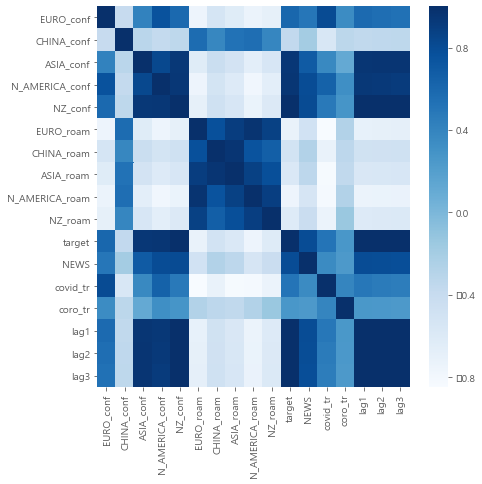

In [12]:
plt.figure(figsize=(7,7))
sns.heatmap(df.corr(), cmap='Blues')

# X_변수 정의

In [13]:
X_cols = list(df.columns)
X_cols.remove('target')

In [14]:
#new_x_cols = X_cols[:5] + X_cols[11:]

In [15]:
test_data_size = 14
# X변수들과 y변수 구분
X = df[X_cols]
y = df['target']

In [16]:
# Train, Test set split
X_train, X_test = X[:-test_data_size], X[-test_data_size:]
y_train, y_test = y[:-test_data_size], y[-test_data_size:]

### 2-1. 모델생성

#### 2-1-1) 기본 옵션으로 모델 생성

In [17]:
rf_uncustomized = RandomForestRegressor()
rf_uncustomized.fit(X_train, y_train)
# Train 데이터 설명력
print("Score on training set : {:.3f}".format(rf_uncustomized.score(X_train,y_train)))
print("Score on test set : {:.3f}".format(rf_uncustomized.score(X_test,y_test)))

ValueError: could not convert string to float: '2020-01-25'

#### 2-1-2) 현재 생성된 트리 모델의 옵션 확인

In [18]:
rf_uncustomized

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

### 2-2. 모델 Parameter 조정

#### 2-2-1) n_estimator : 트리 수 변경에 따른 모델 성능

In [19]:
train_score = []; test_score = []

para_n_tree = [n_tree * 10 for n_tree in range(1,40)]

for v_n_estimators in para_n_tree :
    rf = RandomForestRegressor(n_estimators= v_n_estimators)
    rf.fit(X_train, y_train)
    train_score.append(rf.score(X_train, y_train))
    test_score.append(rf.score(X_test,y_test))

# 결과 저장

df_score_n = pd.DataFrame()
df_score_n['n_estimators'] = para_n_tree
df_score_n['TrainScore'] = train_score
df_score_n['TestScore'] = test_score
df_score_n['Gap'] = df_score_n['TrainScore'] - df_score_n['TestScore']

In [20]:
# 모델 설명력 확인
df_score_n.round(3).sort_values(by='Gap').head()

,n_estimators,TrainScore,TestScore,Gap
5,60,0.999,0.948,0.050
14,150,0.998,0.946,0.052
22,230,0.998,0.946,0.053
34,350,0.998,0.945,0.054
29,300,0.999,0.943,0.055


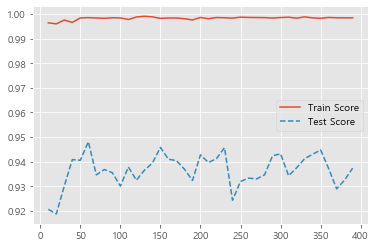

In [21]:
# 모델 설명력 그래프 확인

plt.plot(para_n_tree, train_score, linestyle = "-", label = 'Train Score')
plt.plot(para_n_tree, test_score, linestyle = '--', label = 'Test Score')
plt.legend()

#### 2-2-2) min_samples_leaf : 잎사귀 노드의 최소 자료 수 변경에 따른 모델 성능

In [22]:
train_score = []; test_score = []

para_leaf = [n_leaf * 1 for n_leaf in range(1,21)]

for v_min_samples_leaf in para_leaf :
    rf = RandomForestRegressor(n_estimators=60,
                                min_samples_leaf = v_min_samples_leaf)
    rf.fit(X_train, y_train)
    train_score.append(rf.score(X_train, y_train))
    test_score.append(rf.score(X_test,y_test))
    
# 결과 저장

df_score_leaf = pd.DataFrame()
df_score_leaf['MinSamplesLeaf'] = para_leaf
df_score_leaf['TrainScore'] = train_score
df_score_leaf['TestScore'] = test_score
df_score_leaf['Gap'] = df_score_leaf['TrainScore'] - df_score_leaf['TestScore']

In [23]:
# 모델 설명력 확인
df_score_leaf.round(3).sort_values(by='Gap').head()

,MinSamplesLeaf,TrainScore,TestScore,Gap
16,17,0.788,0.786,0.002
2,3,0.994,0.949,0.045
3,4,0.989,0.931,0.058
1,2,0.997,0.928,0.068
0,1,0.998,0.923,0.075


> leaf는 9개로한다.

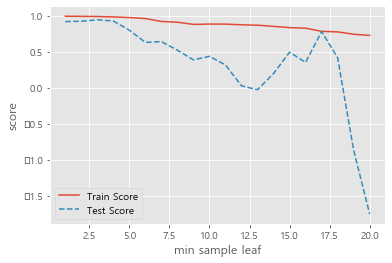

In [24]:
# 모델 설명력 그래프 확인

plt.plot(para_leaf, train_score, linestyle = "-", label = 'Train Score')
plt.plot(para_leaf, test_score, linestyle = '--', label = 'Test Score')
plt.ylabel('score'); plt.xlabel("min sample leaf")
plt.legend()

#### 2-2-3) min_samples_split : 분리노드의 최소 자료 수 변경에 따른 모델 성능

In [25]:
train_score = []; test_score = []

para_split = [n_split * 2 for n_split in range(2,41)]

for v_min_samples_split in para_split :
    rf = RandomForestRegressor(n_estimators=60,
                                 min_samples_leaf = 3,
                                min_samples_split = v_min_samples_split)
    rf.fit(X_train, y_train)
    train_score.append(rf.score(X_train, y_train))
    test_score.append(rf.score(X_test, y_test))
    
# 결과 저장

df_score_split = pd.DataFrame()
df_score_split['MinSamplesSplit'] = para_split
df_score_split['TrainScore'] = train_score
df_score_split['TestScore'] = test_score
df_score_split['Gap'] = df_score_split['TrainScore'] - df_score_split['TestScore']

In [26]:
# 모델 설명력 확인
df_score_split.round(3).sort_values(by='Gap').head()

,MinSamplesSplit,TrainScore,TestScore,Gap
1,6,0.995,0.953,0.042
0,4,0.994,0.932,0.063
2,8,0.990,0.918,0.072
3,10,0.982,0.821,0.161
14,32,0.893,0.670,0.223


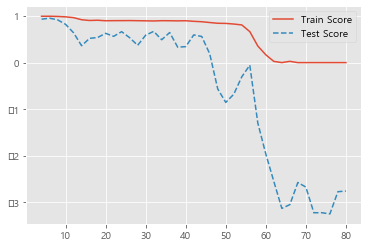

In [27]:
# 모델 설명력 그래프 확인

plt.plot(para_split, train_score, linestyle = "-", label = 'Train Score')
plt.plot(para_split, test_score, linestyle = '--', label = 'Test Score')
plt.legend()

# GridSearch

In [233]:
param_grid = { 
    'n_estimators': [30, 110, 140],
    'min_samples_leaf' : [4, 18, 3],
    'min_samples_split' : [8, 4, 6],
}

In [234]:
# grid search
CV_rfc = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)

In [235]:
CV_rfc

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=4,
                                             min_samples_split=80,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=140, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_j

In [236]:
CV_rfc.fit(X, y)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=4,
                                             min_samples_split=80,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=140, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_j

In [237]:
CV_rfc.best_params_

{'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 140}

## Feature Selection 1

In [28]:
X_cols = list(df.columns)
X_cols.remove('target')

In [29]:
test_data_size = 14
# X변수들과 y변수 구분
X = df[X_cols]
y = df['target']


In [57]:
# Train, Test set split
X_train, X_test = X[:-test_data_size], X[-test_data_size:]
y_train, y_test = y[:-test_data_size], y[-test_data_size:]

In [30]:
# parameter 설정
rf = RandomForestRegressor(n_estimators=60, min_samples_leaf=3, min_samples_split=6, max_features='auto')
rf.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=6,
                      min_weight_fraction_leaf=0.0, n_estimators=60,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [31]:
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance['Feature'] = list(X.columns)
df_importance['Importance'] = rf.feature_importances_

# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values("Importance", ascending = False, inplace = True)
df_importance.round(3).head(20)

,Feature,Importance
4,OCEANIA_conf,0.449
12,lag1,0.315
0,EURO_conf,0.073
14,lag3,0.061
1,CHINA_conf,0.019
2,ASIA_conf,0.018
3,N_AMERICA_conf,0.013
10,NEWS,0.010
5,EURO_roam,0.010
8,N_AMERICA_roam,0.010


In [32]:
new_importance = df_importance[df_importance['Importance'] > 0.01]

In [33]:
#df_importance.to_csv('feature_importance.csv')

Text(0, 0.5, '변수')

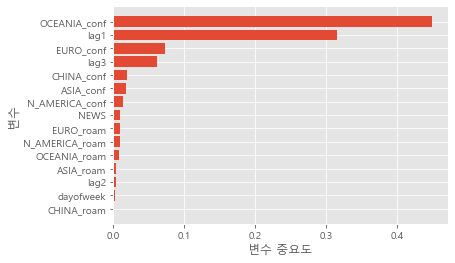

In [34]:
# 설명변수 중요도 그래
# 중요도가 높은 변수를 상위에 그림
# 상위 10개 확인
df_importance1 = df_importance.head(15)
df_importance1.sort_values("Importance", ascending = True, inplace = True)
coordinates = range(len(df_importance1))
plt.barh(y = coordinates,
        width = df_importance1['Importance'])
plt.yticks(coordinates, df_importance1['Feature'])
plt.xlabel('변수 중요도')
plt.ylabel('변수')

# Feature Selection 2

# Prediction

In [35]:
new_x_cols = list(new_importance['Feature'])

In [39]:
X_cols = list(df.columns)
X_cols.remove('target')


# 테스트 데이터 수
test_data_size = 14
# X변수들과 y변수 구분

# # 앞의 40개는 지우기
# X = df[40:][new_x_cols]
# y = df[40:]['target']

X = df[X_cols]
y = df['target']

In [40]:
# Train, Test set split
X_train, X_test = X[:-test_data_size], X[-test_data_size:]
y_train, y_test = y[:-test_data_size], y[-test_data_size:]

In [41]:
X_train.shape

(88, 15)

In [294]:
from sklearn.ensemble.forest import RandomForestRegressor

In [295]:
param_grid = { 
    'n_estimators': [110, 130, 370],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_leaf' : [17, 4, 2],
    'min_samples_split' : [8, 4, 6],
}

In [43]:
# build our RF model
RF_Model = RandomForestRegressor(n_estimators=60, min_samples_leaf=3, min_samples_split=6, max_features='auto')

# let's get the labels and features in order to run our 
# model fitting
labels = y_train
features = X_train

# Fit the RF model with features and labels.
rgr=RF_Model.fit(features, labels)

In [44]:
# Now that we've run our models and fit it, let's create
# dataframes to look at the results
X_test_predict=pd.DataFrame(
    rgr.predict(X_test)).rename(
    columns={0:'predict'})
X_train_predict=pd.DataFrame(
    rgr.predict(X_train)).rename(
    columns={0:'predict'})

# combine the training and testing dataframes to visualize
# and compare.
RF_predict = X_train_predict.append(X_test_predict)

In [45]:
rgr.predict(X_test)

array([8.93328042, 9.48915524, 7.48815476, 8.2506746 , 7.55511243,
       8.61325397, 8.50416667, 8.26369048, 7.58999339, 7.25668651,
       8.92136243, 7.42029762, 7.84982143, 7.39537698])

In [46]:
RF_predict.set_index(pd.to_datetime(df.index, format='%Y%m%d'), inplace=True)

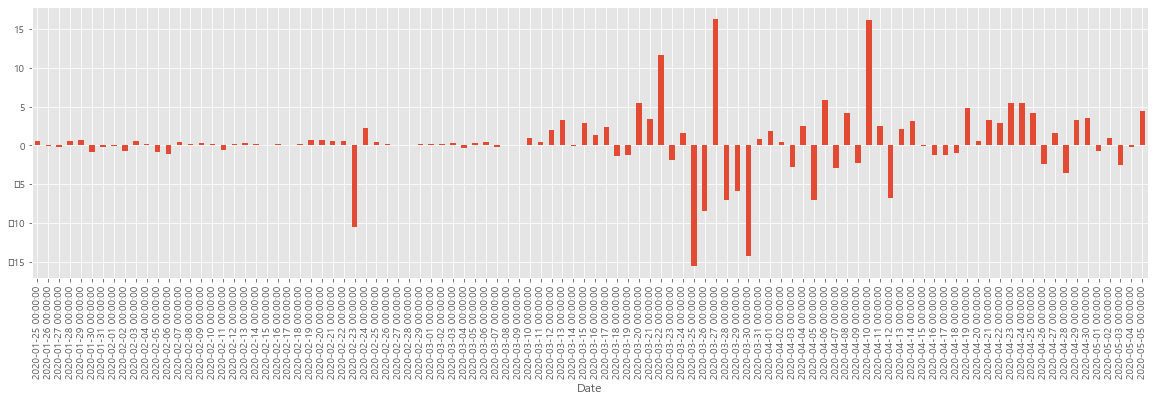

In [47]:
plt.figure(figsize=(20,5))
RF_predict['diff']=RF_predict.predict - df.target
RF_predict['diff'].plot(kind='bar')

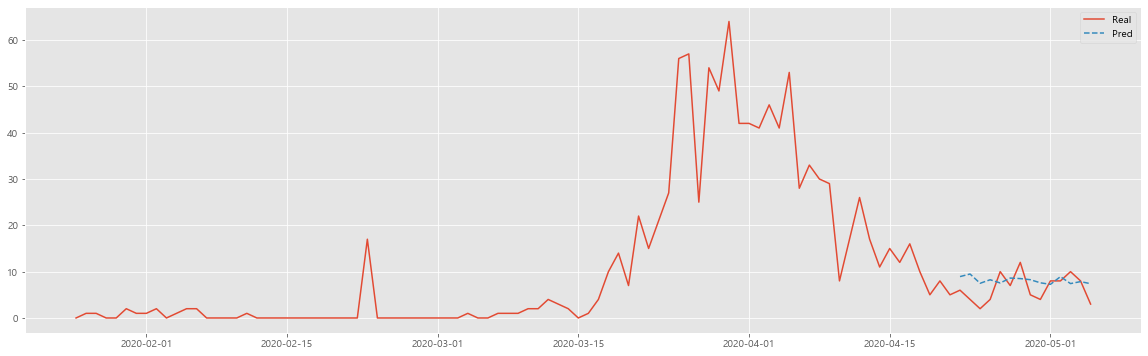

In [48]:
plt.figure(figsize=(20,6))
plt.plot(df['target'], label='Real')
plt.plot(RF_predict['predict'][-len(X_test):], '--',label='Pred', )
plt.legend()

In [49]:
rgr.predict(X_test)

array([8.93328042, 9.48915524, 7.48815476, 8.2506746 , 7.55511243,
       8.61325397, 8.50416667, 8.26369048, 7.58999339, 7.25668651,
       8.92136243, 7.42029762, 7.84982143, 7.39537698])

In [50]:
from sklearn.metrics import r2_score
RSquared = r2_score(y_train, X_train_predict.values)

In [51]:
RSquared

0.9320226891575759

In [52]:
rgr.predict(X_test)

array([8.93328042, 9.48915524, 7.48815476, 8.2506746 , 7.55511243,
       8.61325397, 8.50416667, 8.26369048, 7.58999339, 7.25668651,
       8.92136243, 7.42029762, 7.84982143, 7.39537698])

In [53]:
preds = pd.DataFrame({'real':y_test,'pred':rgr.predict(X_test)})

In [54]:
preds['gap'] = preds.real - preds.pred

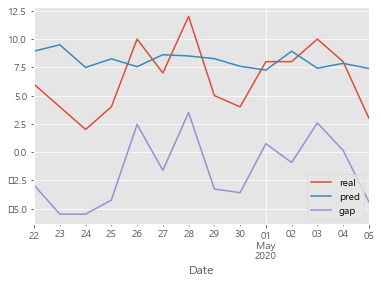

In [55]:
preds.plot()

In [56]:
from sklearn.metrics import mean_squared_error
# validation score
MSE = mean_squared_error(y_test, rgr.predict(X_test))
RMSE = np.sqrt(MSE)
score = 100*(1-(((rgr.predict(X_test) - y_test)**2).sum())/(rgr.predict(X_test)**2).sum())

In [57]:
print("MSE : {0}, RMSE : {1}, SCORE : {2}".format(MSE, RMSE, score))

MSE : 11.332989956889762, RMSE : 3.366450646733108, SCORE : 82.88624306094815
